In [ ]:
Theil's U Statistic: 0.4715

Epoch [1/30], Loss: 14.3854
Epoch [2/30], Loss: 9.8528
Epoch [3/30], Loss: 6.1622
Epoch [4/30], Loss: 5.5360
Epoch [5/30], Loss: 5.2494
Epoch [6/30], Loss: 5.1283
Epoch [7/30], Loss: 4.8772
Epoch [8/30], Loss: 4.7457
Epoch [9/30], Loss: 4.5692
Epoch [10/30], Loss: 4.5182
Epoch [11/30], Loss: 4.3843
Epoch [12/30], Loss: 4.2323
Epoch [13/30], Loss: 4.1702
Epoch [14/30], Loss: 4.1039
Epoch [15/30], Loss: 4.1091
Epoch [16/30], Loss: 4.0678
Epoch [17/30], Loss: 4.1247
Epoch [18/30], Loss: 3.9316
Epoch [19/30], Loss: 3.9435
Epoch [20/30], Loss: 3.9240
Epoch [21/30], Loss: 3.8197
Epoch [22/30], Loss: 3.8791
Epoch [23/30], Loss: 3.8345
Epoch [24/30], Loss: 3.7923
Epoch [25/30], Loss: 3.8101
Epoch [26/30], Loss: 3.7732
Epoch [27/30], Loss: 3.7462
Epoch [28/30], Loss: 3.7685
Epoch [29/30], Loss: 3.7146
Epoch [30/30], Loss: 3.7013


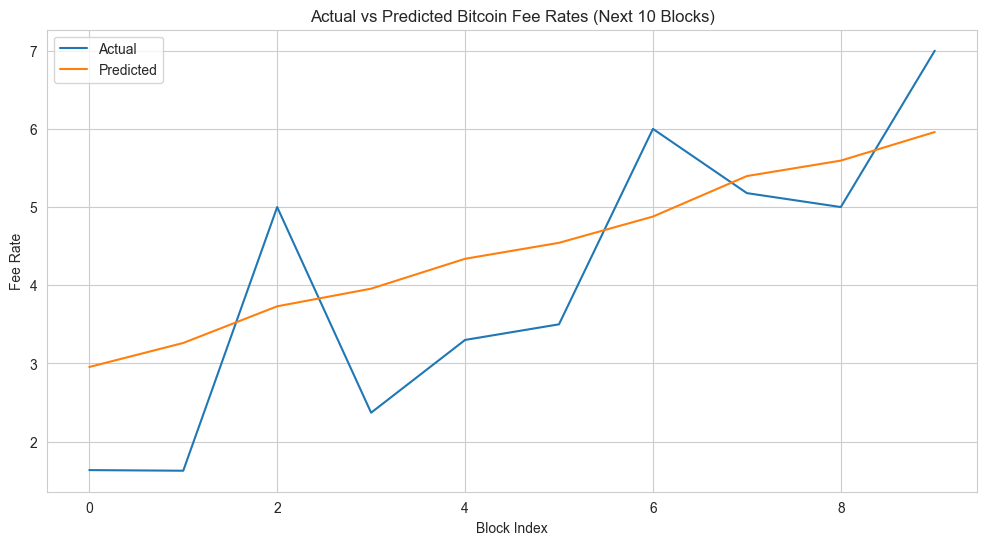


Bitcoin Fee Prediction Model Performance for Next 10 Blocks:
Mean Absolute Error: 1.0865
Mean Squared Error: 1.3447
Root Mean Squared Error: 1.1596
R-squared Score: 0.5659
MAPE: 38.4409%
Directional Accuracy: 55.5556%
Theil's U Statistic: 0.3448
Training time: 105.59s


In [11]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random

start = time.time()

# Set a fixed seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function to set the seed
set_seed(42)

# Load and preprocess data
df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')

# Feature Selection (excluding 'mempool_fee_histogram')
features = [
    'block_height', 'tx_count', 'mempool_size_mb', 'max_fee_rate', 'avg_fee_rate',
    'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
    'difficulty', 'hash_rate', 'mempool_min_fee', 'total_fee', 'mempool_usage',
    'transaction_count', 'block_weight', 'block_version', 'block_interval',
    'bitcoin_price_usd', 'hist_low_fee_ratio',
    'hist_med_fee_ratio', 'hist_high_fee_ratio', 'hist_fee_diversity'
]

future_known_features = [
    'block_height',
    'difficulty',
    'hash_rate',
    'bitcoin_price_usd',
    'block_version'
]

historical_features = [
    'tx_count', 'mempool_size_mb', 'max_fee_rate',
    'avg_fee_rate', 'median_fee_rate', 'fee_rate_10th',
    'fee_rate_90th', 'fee_rate_std', 'mempool_min_fee',
    'total_fee', 'mempool_usage', 'transaction_count',
    'block_weight', 'block_interval', 'hist_low_fee_ratio',
    'hist_med_fee_ratio', 'hist_high_fee_ratio', 'hist_fee_diversity'
]

# Scaling selected features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Prepare data for predicting the next 10 blocks
df['time_idx'] = (df['block_time'] - df['block_time'].min()).dt.total_seconds() // 600  # 10-minute intervals
df['time_idx'] = df['time_idx'].astype(int)  # Ensure time_idx is of type integer
df = df[:-10]  #change to -144 if want to predict next day

target = 'block_median_fee_rate'
max_encoder_length = 144  # Past 144 observations (24 hours)
max_prediction_length = 10  # Predict next 10 blocks (100 minutes) change to 144 if want to predict next day

# Time2Vec layer
class Time2Vec(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Time2Vec, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(input_dim, output_dim-1))
        self.b = nn.parameter.Parameter(torch.randn(output_dim-1))
        self.f = torch.sin

    def forward(self, x):
        v1 = torch.matmul(x, self.w0) + self.b0
        v2 = self.f(torch.matmul(x, self.w) + self.b)
        return torch.cat([v1, v2], -1)

# Define custom dataset
class Time2VecDataset(Dataset):
    def __init__(self, data, historical_features, future_known_features, target, max_encoder_length, max_prediction_length):
        self.data = data
        self.historical_features = historical_features
        self.future_known_features = future_known_features
        self.target = target
        self.max_encoder_length = max_encoder_length
        self.max_prediction_length = max_prediction_length

    def __len__(self):
        return len(self.data) - self.max_encoder_length - self.max_prediction_length + 1

    def __getitem__(self, idx):
        encoder_start = idx
        encoder_end = idx + self.max_encoder_length
        decoder_end = encoder_end + self.max_prediction_length

        historical_data = self.data.iloc[encoder_start:encoder_end][self.historical_features]
        future_known_data = self.data.iloc[encoder_end:decoder_end][self.future_known_features]
        target_values = self.data.iloc[encoder_end:decoder_end][self.target]

        # Create time feature (assuming each step is 10 minutes apart)
        time_feature = torch.arange(0, self.max_encoder_length, dtype=torch.float32).unsqueeze(1)

        x_hist = torch.tensor(historical_data.values, dtype=torch.float)
        x_future = torch.tensor(future_known_data.values, dtype=torch.float)
        y = torch.tensor(target_values.values, dtype=torch.float)

        return time_feature, x_hist, x_future, y

# Create dataset and dataloaders
dataset = Time2VecDataset(df, historical_features, future_known_features, target, max_encoder_length, max_prediction_length)
batch_size = 32
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Define updated model
class BitcoinFeeModel(nn.Module):
    def __init__(self, hist_input_dim, future_input_dim, time2vec_dim, hidden_dim, output_dim, num_predictions, dropout_rate=0.3):
        super(BitcoinFeeModel, self).__init__()
        self.time2vec = Time2Vec(1, time2vec_dim)
        self.lstm = nn.LSTM(hist_input_dim + time2vec_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_combine = nn.Linear(hidden_dim + future_input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.num_predictions = num_predictions

    def forward(self, time_feature, x_hist, x_future):
        batch_size, seq_len, _ = x_hist.shape
        time_encoded = self.time2vec(time_feature).expand(batch_size, seq_len, -1)
        x_hist_time = torch.cat([x_hist, time_encoded], dim=-1)
        
        _, (h_n, _) = self.lstm(x_hist_time)
        h_n = h_n.squeeze(0)
        h_n = self.dropout(h_n)
        
        outputs = []
        for i in range(self.num_predictions):
            combined = torch.cat((h_n, x_future[:, i, :]), dim=1)
            hidden = self.fc_combine(combined)
            hidden = self.dropout(hidden)
            out = self.fc_out(hidden)
            outputs.append(out)
        
        return torch.cat(outputs, dim=1)

# Model parameters
hist_input_dim = len(historical_features)
future_input_dim = len(future_known_features)
time2vec_dim = 16
hidden_dim = 64
output_dim = 1
num_predictions = max_prediction_length
dropout_rate = 0.8

# Instantiate model, loss function, and optimizer
model = BitcoinFeeModel(hist_input_dim, future_input_dim, time2vec_dim, hidden_dim, output_dim, num_predictions, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 30 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for time_feature, x_hist, x_future, y in train_dataloader:
        time_feature, x_hist, x_future, y = time_feature.to(device), x_hist.to(device), x_future.to(device), y.to(device)

        # Forward pass
        outputs = model(time_feature, x_hist, x_future)
        loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Make future predictions
def predict_future(model, data, historical_features, future_known_features, max_encoder_length, max_prediction_length):
    model.eval()
    hist_data = data.tail(max_encoder_length)[historical_features].values
    last_block_height = data['block_height'].iloc[-1]
    
    future_data = data.tail(max_prediction_length)[future_known_features].values
    for i in range(max_prediction_length):
        future_data[i, future_known_features.index('block_height')] = last_block_height + i + 1
    
    time_feature = torch.arange(0, max_encoder_length, dtype=torch.float32).unsqueeze(1).to(device)
    x_hist = torch.tensor(hist_data, dtype=torch.float).unsqueeze(0).to(device)
    x_future = torch.tensor(future_data, dtype=torch.float).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(time_feature, x_hist, x_future).cpu().numpy().flatten()

    return predictions

# Predict next 10 blocks
future_predictions = predict_future(model, df, historical_features, future_known_features, max_encoder_length, max_prediction_length)

df = pd.read_csv('real_time_cleaned.csv')
# Plot results
plt.figure(figsize=(12, 6))
y_true = df[target].iloc[-max_prediction_length:].values
plt.plot(range(len(y_true)), y_true, label='Actual')
plt.plot(range(len(future_predictions)), future_predictions, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 10 Blocks)')
plt.xlabel('Block Index')
plt.ylabel('Fee Rate')
plt.legend()
plt.show()

# Calculate performance metrics
mae = mean_absolute_error(y_true, future_predictions)
mse = mean_squared_error(y_true, future_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, future_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the percent changes
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]  # Use y_true[:-1] as the base for both
    
    # Calculate Theil's U statistic
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator

mape = mean_absolute_percentage_error(y_true, future_predictions)
da = directional_accuracy(y_true, future_predictions)
theils_u = theil_u(y_true, future_predictions)
end = time.time()

print("\nBitcoin Fee Prediction Model Performance for Next 10 Blocks:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"Directional Accuracy: {da:.4f}%")
print(f"Theil's U Statistic: {theils_u:.4f}")
print(f"Training time: {end-start:.2f}s")

In [12]:
df

,block_time,block_height,tx_count,mempool_size_mb,max_fee_rate,avg_fee_rate,median_fee_rate,fee_rate_10th,fee_rate_90th,fee_rate_std,...,block_weight,block_version,block_interval,block_median_fee_rate,mempool_fee_histogram,bitcoin_price_usd,hist_low_fee_ratio,hist_med_fee_ratio,hist_high_fee_ratio,hist_fee_diversity
0,2024-09-16 06:44:46,861523,59716.0,51.681340,268.622239,1.8891,2.0068,1.0166,2.079400,1.51452,...,3993295.0,689364992,425.000000,2.1032,"[59691, 10, 7, 1, 2, 1, 1, 2, 0, 1]",58657.0,0.999581,0.000335,0.000084,0.888889
1,2024-09-16 07:01:15,861524,57979.0,50.830730,15.052460,1.7086,2.0039,1.0160,2.071400,0.47300,...,3993188.0,838860800,989.000000,4.0000,"[57633, 317, 15, 7, 2, 2, 1, 1, 0, 1]",58657.0,0.994969,0.004852,0.000086,0.888889
2,2024-09-16 07:05:01,861525,53178.0,50.142707,25.118500,1.6743,2.0000,1.0157,2.071400,0.50320,...,3993640.0,551452672,226.000000,2.0794,"[53136, 24, 8, 5, 1, 0, 1, 2, 0, 1]",58701.0,0.999210,0.000715,0.000075,0.777778
3,2024-09-16 07:34:53,861526,58865.0,51.178547,268.622239,1.7449,2.0068,1.0160,2.079400,1.33970,...,3993080.0,620822528,1354.594323,4.8216,"[58864, 0, 0, 0, 0, 0, 0, 0, 0, 1]",58863.0,0.999953,0.000000,0.000017,0.111111
4,2024-09-16 07:35:35,861527,53746.0,50.270880,70.000000,1.6885,2.0000,1.0157,2.071400,0.69170,...,3992931.0,827326464,42.000000,2.0952,"[53717, 14, 7, 3, 3, 1, 0, 0, 0, 1]",58863.0,0.999460,0.000502,0.000037,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,2024-10-04 23:32:24,864203,51205.0,40.779730,28.358400,1.3241,1.0426,1.0104,1.661400,0.78920,...,3993729.0,537133056,687.000000,3.5000,"[51062, 58, 21, 7, 1, 13, 21, 15, 3, 4]",62026.0,0.997207,0.001699,0.000120,1.000000
2628,2024-10-04 23:46:25,864204,53237.0,41.272513,61.150300,1.4240,1.1040,1.0104,1.876900,1.23240,...,3993753.0,808083456,841.000000,6.0000,"[53090, 59, 34, 14, 20, 13, 3, 1, 0, 3]",62038.0,0.997239,0.002386,0.000120,0.888889
2629,2024-10-05 00:07:40,864205,55672.0,42.025592,93.076900,1.6784,1.1534,1.0104,2.086314,1.51452,...,3993139.0,700538880,1275.000000,5.1783,"[55590, 36, 12, 4, 3, 4, 0, 1, 13, 9]",62129.0,0.998527,0.000988,0.000120,0.888889
2630,2024-10-05 00:08:03,864206,50943.0,41.099007,96.263600,1.3575,1.0426,1.0104,1.634900,1.01580,...,3993460.0,543162368,23.000000,5.0000,"[50895, 29, 14, 2, 2, 0, 0, 0, 0, 1]",62129.0,0.999058,0.000923,0.000020,0.555556
